<a href="https://colab.research.google.com/github/danielbauer1979/CAS_PredMod/blob/main/pa_pynb_sess3_GLMCaseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Session 3 -- GLM Case Study

Dani Bauer, 9/12/2022

In this tutorial, we will present a detailed case study in the context of auto liability insurance, showcasing a variety of GLM techniques.

Let's start by loading the libraries that are going to be helpful. Again, we're going to rely on the statistical learning toolkit ski-cit learn, which provides GLM functionalty but also will be used in the context of algorithmic learners. It is less comfortable to use than some of the other packages and, unlike R, does not support formulas. But it is versatile and fast, and therefore one of the most popular prdictive modeling toolkits.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor
from sklearn.linear_model import GammaRegressor

We consider predictive modeling of auto claims, i.e. the overarching challenge is predicting frequencies and/or severities of claims.  We rely on the comprehensive French Motor Third-Part Liability datasets `ferMTPLfreq` and `ferMTPLsev` available within the [package CASdatasets](http://cas.uqam.ca/).

Let's take a peak, first at the frequency dataset:

In [7]:
!git clone https://github.com/danielbauer1979/CAS_PredMod.git

Cloning into 'CAS_PredMod'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 46 (delta 15), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (46/46), done.


In [8]:
dat_frq1 = pd.read_csv('CAS_PredMod/pa_data_freMTPLfreq1.csv')
dat_frq2 = pd.read_csv('CAS_PredMod/pa_data_freMTPLfreq2.csv')
dat_frq = pd.concat([dat_frq1,dat_frq2])
dat_frq.head() 

,Unnamed: 0,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density
0,1,1,0,0.09,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76
1,2,2,0,0.84,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76
2,3,3,0,0.52,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003
3,4,4,0,0.45,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003
4,5,5,0,0.15,g,0,41,Japanese (except Nissan) or Korean,Diesel,Pays-de-la-Loire,60


In [9]:
dat_frq.describe()

,Unnamed: 0,PolicyID,ClaimNb,Exposure,CarAge,DriverAge,Density
count,413169.000000,413169.000000,413169.000000,413169.000000,413169.000000,413169.000000,413169.000000
mean,206585.000000,206585.000000,0.039163,0.561088,7.532404,45.319876,1985.153913
std,119271.761023,119271.761023,0.204053,0.369477,5.763011,14.328120,4776.254543
min,1.000000,1.000000,0.000000,0.002732,0.000000,18.000000,2.000000
25%,103293.000000,103293.000000,0.000000,0.200000,3.000000,34.000000,67.000000
50%,206585.000000,206585.000000,0.000000,0.540000,7.000000,44.000000,287.000000
75%,309877.000000,309877.000000,0.000000,1.000000,12.000000,54.000000,1410.000000
max,413169.000000,413169.000000,4.000000,1.990000,100.000000,99.000000,27000.000000


In [10]:
pd.crosstab(index=dat_frq['ClaimNb'], columns="count")

col_0,count
ClaimNb,
0,397779
1,14633
2,726
3,28
4,3


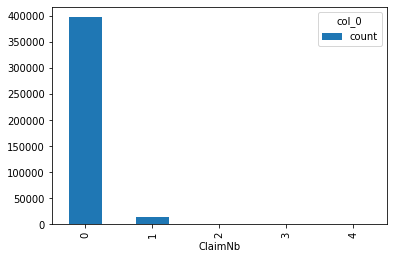

In [11]:
pd.crosstab(index=dat_frq['ClaimNb'], columns="count").plot(kind='bar')

So, as expected, multiple claims are rare. The vast majority of cases don't have a claim.

Let's look at the severities:

In [13]:
dat_sev = pd.read_csv('CAS_PredMod/pa_data_freMTPLsev.csv')
print(dat_sev.shape)
dat_sev.head() 

(16181, 3)


,Unnamed: 0,PolicyID,ClaimAmount
0,1,63987,1172
1,2,310037,1905
2,3,314463,1150
3,4,318713,1220
4,5,309380,55077


In [14]:
dat_sev.describe()

,Unnamed: 0,PolicyID,ClaimAmount
count,16181.000000,16181.000000,1.618100e+04
mean,8091.000000,185015.202151,2.129972e+03
std,4671.196688,117946.980398,2.106364e+04
min,1.000000,33.000000,2.000000e+00
25%,4046.000000,83922.000000,6.980000e+02
50%,8091.000000,169907.000000,1.156000e+03
75%,12136.000000,281599.000000,1.243000e+03
max,16181.000000,412944.000000,2.036833e+06


So, again, as expected, we have a few very large claims.

## Merge the Data Sets

Since there are multiple claims for each policy, let's summarize the claims to the policy level, so as to allow for an easy merge:

In [15]:
df = dat_sev.groupby('PolicyID', as_index=False).agg({"ClaimAmount":"mean"})
df

,PolicyID,ClaimAmount
0,33,302.0
1,41,2001.0
2,92,1449.0
3,96,5435.0
4,142,1390.0
...,...,...
15385,412262,1426.0
15386,412270,1364.0
15387,412664,7603.0
15388,412926,1751.0


Now we can simply merge the frequency and the severity sets into our master data set, where we set the `NA` `ClaimAmount` entries to zero where we don't have claims: 

In [16]:
dat = pd.merge(dat_frq, dat_sev.groupby('PolicyID', as_index=False).agg({"ClaimAmount":"mean"}),how='left')
dat = dat.fillna(0)
dat.head()

,Unnamed: 0,PolicyID,ClaimNb,Exposure,Power,CarAge,DriverAge,Brand,Gas,Region,Density,ClaimAmount
0,1,1,0,0.09,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0.0
1,2,2,0,0.84,g,0,46,Japanese (except Nissan) or Korean,Diesel,Aquitaine,76,0.0
2,3,3,0,0.52,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,0.0
3,4,4,0,0.45,f,2,38,Japanese (except Nissan) or Korean,Regular,Nord-Pas-de-Calais,3003,0.0
4,5,5,0,0.15,g,0,41,Japanese (except Nissan) or Korean,Diesel,Pays-de-la-Loire,60,0.0


## Building Models

As the previous time, we need to put the categorical variables to dummies. For that, we separate the dummies and the numerical variables, make the dummies, and then concatenate.

In [17]:
dummies = pd.get_dummies(dat[dat.columns[[4,7,8,9]]])
dat = dat.drop(dat.columns[[0, 1, 4, 7, 8, 9]], axis=1)
dat = pd.concat([dat,dummies], axis=1)
dat.head()

,ClaimNb,Exposure,CarAge,DriverAge,Density,ClaimAmount,Power_d,Power_e,Power_f,Power_g,...,Region_Aquitaine,Region_Basse-Normandie,Region_Bretagne,Region_Centre,Region_Haute-Normandie,Region_Ile-de-France,Region_Limousin,Region_Nord-Pas-de-Calais,Region_Pays-de-la-Loire,Region_Poitou-Charentes
0,0,0.09,0,46,76,0.0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,0,0.84,0,46,76,0.0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
2,0,0.52,2,38,3003,0.0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0.45,2,38,3003,0.0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0.15,0,41,60,0.0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


Let's do some visualizations of some of the variables:

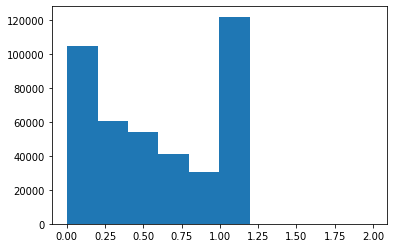

In [18]:
plt.hist(dat['Exposure'])
plt.show()

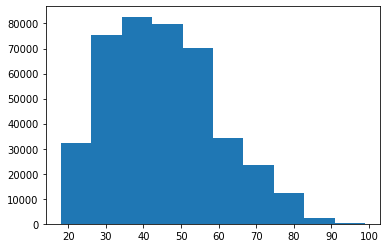

In [19]:
plt.hist(dat['DriverAge'])
plt.show()

...likely what we expected...

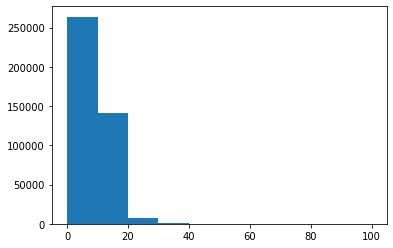

In [20]:
plt.hist(dat['CarAge'])
plt.show()

...also no surprises...

Let's look at population density, that's a more interesting variable:

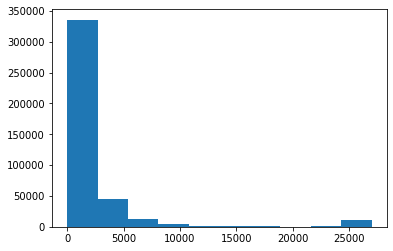

In [21]:
plt.hist(dat['Density'])
plt.show()

So it looks like very small and a few very high densities. Let's go to log-scale.

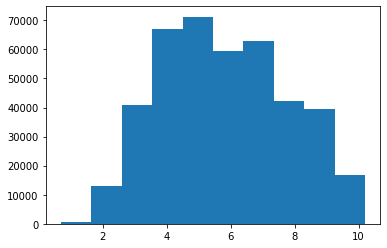

In [22]:
dat.loc[:, 'Density'] = np.log(dat['Density'])
plt.hist(dat['Density'])
plt.show()

Let's also check out our targets: 

In [23]:
dat.loc[dat['ClaimAmount']>0,'ClaimAmount'].quantile([.9, .95, .99, .999])

0.900      2583.100
0.950      4269.100
0.990     16103.355
0.999    131058.421
Name: ClaimAmount, dtype: float64

It is possible that the few very large claims will cause trouble, so let's cut off at 50K:

In [24]:
dat['ClaimAmount'][dat['ClaimAmount']>50000] = 50000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Let's split into a training and a test sample, so that we can evaluate our model:

In [25]:
Train, Test = train_test_split(dat, test_size=0.25)
Train_y_freq = Train['ClaimNb']
Train_y_sev = Train['ClaimAmount']
Train_X = Train.drop(columns = ['ClaimNb','ClaimAmount'])
Test_y_freq = Test['ClaimNb']
Test_y_sev = Test['ClaimAmount']
Test_X = Test.drop(columns = ['ClaimNb','ClaimAmount'])


And let's model frequencies via a Poisson Regression:

In [26]:
freqmodel = PoissonRegressor()
freqmodel.fit(Train_X,Train_y_freq)
preds_Train = freqmodel.predict(Train_X)
np.corrcoef(preds_Train,Train_y_freq)

array([[1.        , 0.02038236],
       [0.02038236, 1.        ]])

The correlation is fairly low, but when we look at a scatter plot...

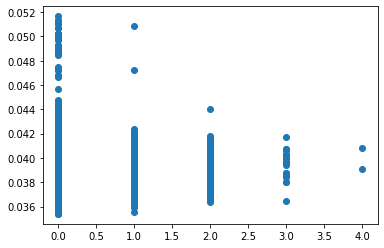

In [27]:
plt.scatter(Train_y_freq,preds_Train)

it does seem like that the claims with higher frequencies have higher predictions, though they are still close to zero:

In [28]:
preds_Test = freqmodel.predict(Test_X)
np.corrcoef(preds_Test,Test_y_freq)

array([[1.        , 0.02292724],
       [0.02292724, 1.        ]])

It seems the positive correlation sustains in the test set (out of sample), and the scatter plot:

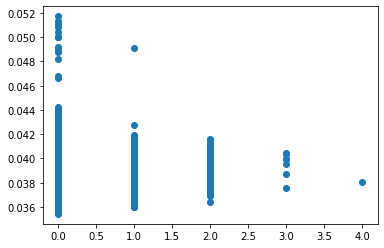

In [29]:
plt.scatter(Test_y_freq,preds_Test)

Also suggests the model isn't crazy.

Let's looks at claims:

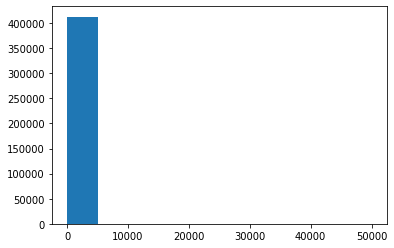

In [30]:
plt.hist(dat['ClaimAmount'])
plt.show()

and non-zero claims on a log-scale.

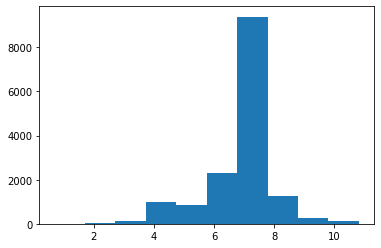

In [31]:
plt.hist(np.log(dat.loc[dat['ClaimAmount']>0,'ClaimAmount']))
plt.show()

Let's run a Gamma regression for the severities:

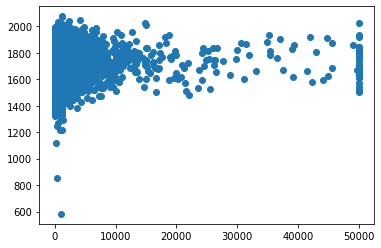

In [32]:
Train = Train.loc[Train['ClaimAmount']>0,:]
Train_y_sev = Train['ClaimAmount']
Train_X = Train.drop(columns = ['ClaimNb','ClaimAmount'])
sevmodel = GammaRegressor()
sevmodel.fit(Train_X,Train_y_sev)
plt.scatter(Train_y_sev,sevmodel.predict(Train_X))

So we're kind-of cathing the trend.

Now we can fuse together by muliplying predicted frequencies and severities:

In [33]:
preds_Test_sev = sevmodel.predict(Test_X)
preds_Test_tot = preds_Test * preds_Test_sev

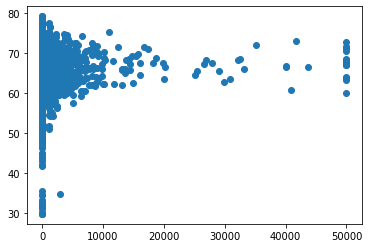

In [34]:
plt.scatter(Test_y_freq * Test_y_sev,preds_Test_tot)